## Soil moisture evolution Schwarzwald (2015- 2022)

1. Map of the Harz Region 
2. Selections of Grid cells for the precipitation, radiation, tempertature and LAI data
3. Running the simple water balance model for the years 2015 to 2022 for the Harz region
4. Make a soil moisture evolution diagramm

### Importing packages 

In [1]:
import folium
import os
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import shutil
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
from mpl_toolkits.basemap import Basemap
import final_model

# Import libraries
from matplotlib import pyplot as plt
import numpy as np
import netCDF4 as nc
import pandas as pd
import xarray as xr
import run

### Reading data

### Map of the Harz region and selection of grid cells

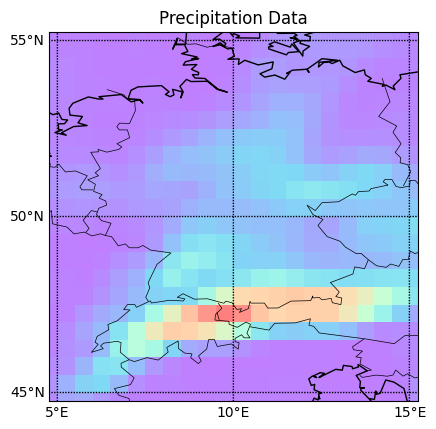

In [2]:
# File paths
precipitation_file = "data/total_precipitation/tp.daily.calc.era5.0d50_CentralEurope.2000.nc"

# Open the NetCDF file
nc_file = nc.Dataset(precipitation_file)
lon = nc_file.variables['lon'][:]
lat = nc_file.variables['lat'][:]
data = nc_file.variables['tp'][50, :, :]  # Using arbitrary time index 50

# Create Basemap instance
m = Basemap(llcrnrlon=lon.min(), llcrnrlat=lat.min(),
            urcrnrlon=lon.max(), urcrnrlat=lat.max(),
            projection='cyl', resolution='l')

# Draw coastlines, countries, and states
m.drawcoastlines()
m.drawcountries()
m.drawstates()

# Plot the precipitation data as grid cells
x_mesh, y_mesh = np.meshgrid(lon, lat)
x_mesh, y_mesh = m(x_mesh, y_mesh)
plt.pcolormesh(x_mesh, y_mesh, data, cmap='rainbow', alpha=0.5, label='Precipitation Data')

# Add latitude and longitude lines with labels
m.drawparallels(np.arange(-90., 91., 5.), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-180., 181., 5.), labels=[0,0,0,1], fontsize=10)

plt.title('Precipitation Data')

# Show the plot
plt.show()

# Close the NetCDF file
nc_file.close()

### Schwarzwald

In [61]:
import folium
import geopandas as gpd

# File path to the Harz shapefile
shapefile_path = "data/schwarzwald_naturpark/naturpark_schwarzwald.shp"

# Load the shapefile using geopandas
schwarzwald_shape = gpd.read_file(shapefile_path, encoding='latin1')

# Create a Folium map
m = folium.Map()

# Add the shapefile to the map
folium.GeoJson(schwarzwald_shape).add_to(m)

# Display the map
m

In [4]:
import geopandas as gpd
from shapely.geometry import box

# File path to the Schwarzwald shapefile
shapefile_path = "data/schwarzwald_naturpark/naturpark_schwarzwald.shp"

# Load the shapefile using geopandas
schwarzwald_shape = gpd.read_file(shapefile_path, encoding='latin1')

# Define the CRS of the shapefile (EPSG:32632)
original_crs = {'init': 'epsg:32632'}

# Convert the bounds to degrees (latitude and longitude)
bounds_deg = schwarzwald_shape.total_bounds
bounds_deg = gpd.GeoSeries([box(bounds_deg[0], bounds_deg[1], bounds_deg[2], bounds_deg[3])], crs=original_crs).to_crs(epsg=4326)[0].bounds
min_lon, min_lat, max_lon, max_lat = bounds_deg

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


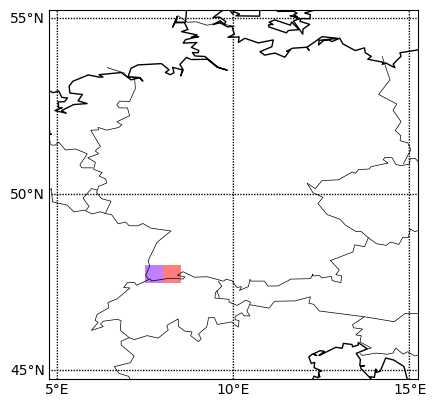

In [62]:
file_path = 'data/total_precipitation/tp.daily.calc.era5.0d50_CentralEurope.2000.nc' 

nc_file = nc.Dataset(file_path)
lon = nc_file.variables['lon'][:]
lat = nc_file.variables['lat'][:]
data = nc_file.variables['tp'][50, :, :]  

# Mask data outside the polygon extent
lon_mask = (lon >= min_lon) & (lon <= max_lon)
lat_mask = (lat >= min_lat) & (lat <= max_lat)
data_masked = np.ma.masked_where(~np.outer(lat_mask, lon_mask), data)

# Create Basemap instance
m = Basemap(llcrnrlon=lon.min(), llcrnrlat=lat.min(),
            urcrnrlon=lon.max(), urcrnrlat=lat.max(),
            projection='cyl', resolution='l')

# Draw coastlines, countries, and states
m.drawcoastlines()
m.drawcountries()
m.drawstates()

# Plot the filtered precipitation data as grid cells
x_mesh, y_mesh = np.meshgrid(lon, lat)
x_mesh, y_mesh = m(x_mesh, y_mesh)
plt.pcolormesh(x_mesh, y_mesh, data_masked, cmap='rainbow', alpha=0.5, label='Precipitation Data')

# Add latitude and longitude lines with labels
m.drawparallels(np.arange(-90., 91., 5.), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-180., 181., 5.), labels=[0,0,0,1], fontsize=10)


# Show the plot
plt.show()

# Close the NetCDF file
nc_file.close()


In [6]:
# Find indices of lon and lat within the specified bounds
lon_idx = np.where((lon >= min_lon) & (lon <= max_lon))[0]
lat_idx = np.where((lat >= min_lat) & (lat <= max_lat))[0]

# Resulting indices
intersecting_lons = lon[lon_idx]
intersecting_lats = lat[lat_idx]

print("Longitude Indices:", lon_idx)
print("Latitude Indices:", lat_idx)
print("Intersecting Longitudes:", intersecting_lons)
print("Intersecting Latitudes:", intersecting_lats)

Longitude Indices: [6 7]
Latitude Indices: [15]
Intersecting Longitudes: [7.75 8.25]
Intersecting Latitudes: [47.75]


In [7]:
years = np.arange(2000,2024,1)

R_data = []
T_data = []
P_data = []
lai_data = []


for year in years:
    file_path = 'data/total_precipitation/tp.daily.calc.era5.0d50_CentralEurope.' + str(year) + '.nc'
    P_data.append(xr.open_dataset(file_path)['tp'][:,lat_idx,lon_idx])

    file_path = 'data/net_radiation/nr.daily.calc.era5.0d50_CentralEurope.' + str(year) + '.nc'
    R_data.append(xr.open_dataset(file_path)['nr'][:,lat_idx,lon_idx])

    file_path = 'data/daily_average_temperature/t2m_mean.daily.calc.era5.0d50_CentralEurope.' + str(year) + '.nc'
    T_data.append(xr.open_dataset(file_path)['t2m'][:,lat_idx,lon_idx])

    file_path = 'data/lai/lai.daily.0d50_CentralEurope.' + str(year) + '.nc'
    lai_data.append(xr.open_dataset(file_path)['lai'][:,lat_idx,lon_idx])

In [8]:
years

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022, 2023])

In [9]:
# Convert lists to xarray datasets
P_data = xr.concat(P_data, dim='time')
R_data = xr.concat(R_data, dim='time')
T_data = xr.concat(T_data, dim='time')
lai_data = xr.concat(lai_data, dim='time')

In [10]:
# Fill LAI with zeros were Na :D (wrong)
lai_data = lai_data.fillna(0)

In [54]:
# Run model for all gridcells 1:30 min for one cell... there are 484 cells

# Paramters
cs = 420 
alpha = 8 
gamma = 0.2 
beta = 0.8
cm = 1.5 
et_weight = (0.75, 0.25)

# Create empty arrays to store the output data
snow = np.zeros_like(P_data)
soil_moisture = np.zeros_like(P_data)
evapotranspiration = np.zeros_like(P_data)
runoff = np.zeros_like(P_data)

# Iteerate through gridcels
for lat in range(len(P_data.lat)):
    for lon in range(len(P_data.lon)):
        
        if np.isnan(lai_data[:, lat, lon]).any():
            print("Na found in gridcell", lat, lon)
            continue

        R_data_grid = R_data[:, lat, lon]
        P_data_grid = P_data[:, lat, lon]
        T_data_grid = T_data[:, lat, lon]
        lai_data_grid = lai_data[:, lat, lon]

        # Run Model for daily values
        daily_output = run.time_evolution(P_data_grid, R_data_grid, T_data_grid, lai_data_grid, cs, alpha,
        gamma, beta, cm, et_weight)

        snow[:, lat, lon] = daily_output['snow'].values
        soil_moisture[:, lat, lon] = daily_output['calculated_soil_moisture'].values
        evapotranspiration[:, lat, lon] = daily_output['evapotranspiration'].values
        runoff[:, lat, lon] = daily_output['runoff'].values
        
    

one done
one done


In [55]:
# Convert arrays to xarrays with corresponding latitudes and longitudes
snow_xr = xr.DataArray(snow, dims=('time', 'lat', 'lon'), coords={'time': P_data.time, 'lat': P_data.lat, 'lon': P_data.lon})
soil_moisture_xr = xr.DataArray(soil_moisture, dims=('time', 'lat', 'lon'), coords={'time': P_data.time, 'lat': P_data.lat, 'lon': P_data.lon})
evapotranspiration_xr = xr.DataArray(evapotranspiration, dims=('time', 'lat', 'lon'), coords={'time': P_data.time, 'lat': P_data.lat, 'lon': P_data.lon})
runoff_xr = xr.DataArray(runoff, dims=('time', 'lat', 'lon'), coords={'time': P_data.time, 'lat': P_data.lat, 'lon': P_data.lon})

In [60]:
import xarray as xr

# Save each xarray.DataArray as a NetCDF file
snow_xr.to_netcdf('data/snow_data_schwarzwald.nc')
soil_moisture_xr.to_netcdf('data/soil_moisture_data_schwarzwald.nc')
evapotranspiration_xr.to_netcdf('data/evapotranspiration_data_schwarzwald.nc')
runoff_xr.to_netcdf('data/runoff_data_schwarzwald.nc')
